# Argosim tutorial - Part 2

In this tutorial we will explore the `uv_track_multiband` function.

In [2]:
# Import the argosim package

import sys

# added the "argosim" directory
sys.path.append(r'C:\Users\manoula\argosim\src')

import argosim

# Import the uv_track_multiband function from the argosim.antenna_utils module
from argosim.antenna_utils import uv_track_multiband

In [3]:
# Display help on the uv_track_multiband function
help(uv_track_multiband)

Help on function uv_track_multiband in module argosim.antenna_utils:

uv_track_multiband(b_ENU, lat=0.6108652381980153, dec=0.6108652381980153, track_time=0.0, t_0=0.0, n_times=1, f=1420000000.0, df=0.0, n_freqs=1, multi_band=False)
    Uv track multiband.
    
    Function to compute the uv sampling baselines for a given observation time and frequency range.
    
    Parameters
    ----------
    b_ENU : np.ndarray
        The baselines in ENU coordinates.
    lat : float
        The latitude of the antenna array in radians.
    dec : float
        The declination of the source in radians.
    track_time : float
        The duration of the tracking in hours.
    t_0 : float
        The initial tracking time in hours.
    n_times : int
        The number of time steps.
    f : float
        The central frequency of the observation in Hz.
    df : float
        The frequency range of the observation in Hz.
    n_freqs : int
        The number of frequency samples.
    multi_band : bool


* Which are the inputs and outputs of the function? What are the default values and in which units the inputs are expressed?

--> Inputs :
b_ENU (np.ndarray) – The baselines in ENU coordinates.

lat (float) – The latitude of the antenna array in radians.

dec (float) – The declination of the source in radians.

track_time (float) – The duration of the tracking in hours.

t_0 (float) – The initial tracking time in hours.

n_times (int) – The number of time steps.

f (float) – The central frequency of the observation in Hz.

df (float) – The frequency range of the observation in Hz.

n_freqs (int) – The number of frequency samples.

multi_band (bool) – If True separate the uv samples per frequency bands.

--> Outputs 
track (np.ndarray) – The uv sampling baselines listed for each time step and frequency.

f_range (np.ndarray) – The list of frequency bands used in the simulation.


# Group the inputs of the function in the following categories: 



- Related to the physical antenna array:

array : antenna position (ENU coordinate)
lat : latitude 
frequencies : Hz 

- Related to the observed source:

dec : declination

- Related to the observation parameters:

track_time : the total duration of observation 

n_time : step 

What does the function return? How are the outputs related to the inputs?

The uv coordinates of the baselines over time, for each frequency.
A numpy array containing this data

### Array location

Run the cell below and explain what the resulting figure represents.

...


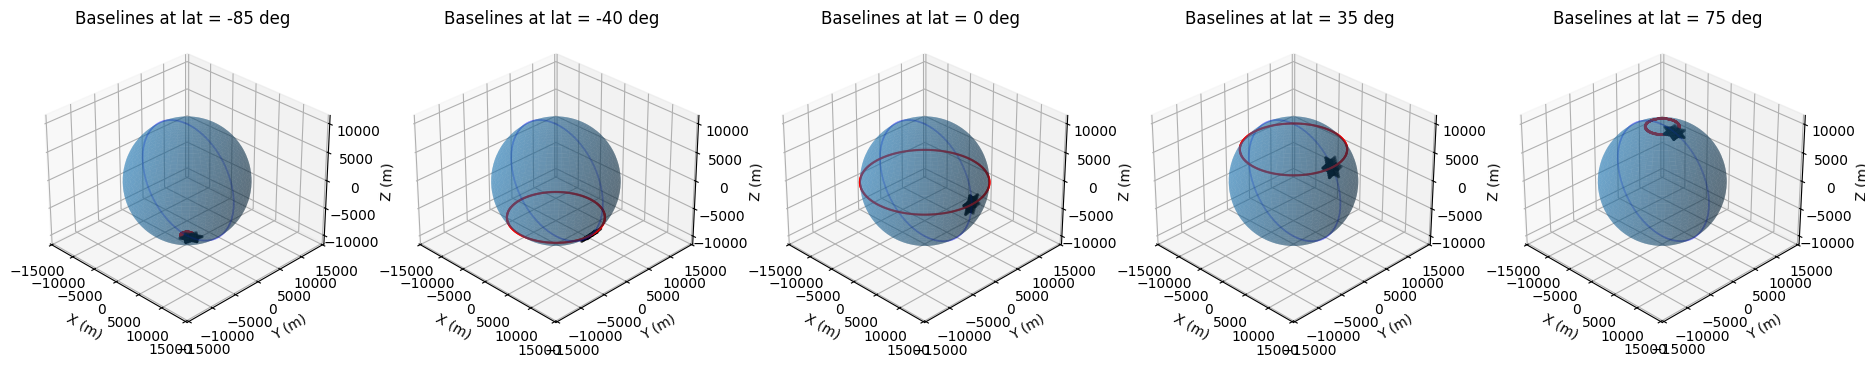

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from argosim import antenna_utils

array_y = antenna_utils.y_antenna_arr(n_antenna=3, r=1000, alpha=13)
array_rand = antenna_utils.random_antenna_arr(n_antenna=3, E_lim=250, N_lim=100, U_lim=0)
array_comby = antenna_utils.combine_antenna_arr(array_y,array_rand)
b_ENU = antenna_utils.get_baselines(array_comby)

fig, ax = plt.subplots(1, 5, figsize=(23, 6), subplot_kw={'projection': '3d'})
l = np.linspace(0, 2 * np.pi, 1000) 
m = np.linspace(0, np.pi, 1000)
R = 10000
x_globe = R * np.outer(np.cos(l), np.sin(m))
y_globe = R * np.outer(np.sin(l), np.sin(m))
z_globe = R * np.outer(np.ones(np.size(l)), np.cos(m))

for i, lat in enumerate([-85, -40, 0, 35, 75]):
    ax[i].plot_surface(x_globe, y_globe, z_globe, alpha=0.4)
    x_shift = R * np.cos(lat/180*np.pi)
    z_shift = R * np.sin(lat/180*np.pi)
    z_circ = np.where((z_globe[0] - z_shift)**2 < 20**2)
    y_circ = np.where((z_globe[0])**2 < 20**2)
    ax[i].scatter(x_globe[:,z_circ], y_globe[:,z_circ], z_globe[:,z_circ], c='r', s=0.3, alpha=0.2)
    ax[i].scatter(x_globe[:,y_circ], z_globe[:,y_circ], y_globe[:,y_circ] , c='b', s=0.1, alpha=0.05)
    X, Y, Z = antenna_utils.ENU_to_XYZ(b_ENU, lat = lat/180*np.pi)

    ax[i].scatter(X + x_shift, Y, Z + z_shift, c='k', s=2)
    ax[i].set_xlabel('X (m)')
    ax[i].set_ylabel('Y (m)')
    ax[i].set_zlabel('Z (m)')
    ax[i].set_title('Baselines at lat = {} deg'.format(lat))
    ax[i].axis('equal')
    # Set up view angle
    ax[i].view_init(elev=30, azim=-45)
plt.show()

What do the numbers we iterate over ([-85, -40, 0, 35, 75]) represent?

-85°: almost Antarctica

-40°: Southern Hemisphere

0°: Equator

35°: Northern Hemisphere

75°: Near the Arctic Circle

How would this impact the observation?

Latitude influences how antennas perceive signals and their baselines. The closer we are to the poles, the more the baseline projections change.

### Source tracking

We will create a radio array and simulate the uv-tracks for different observation strategies.

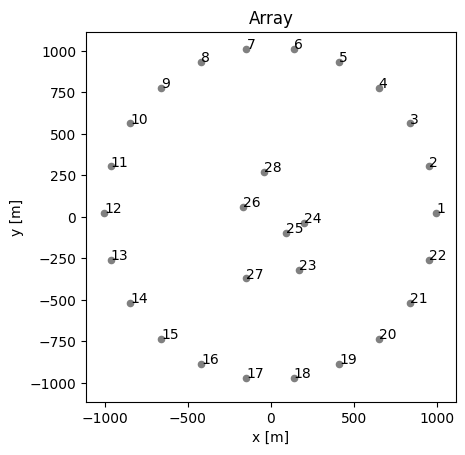

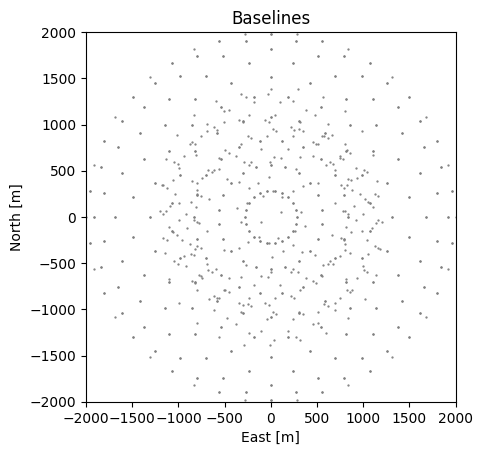

In [5]:
# Create a circular array of 22 antennas with a radius of 1000 m 
# and add 6 antennas randomly distributed inside the circle.
import matplotlib.pyplot as plt
from argosim import plot_utils

circular_array = antenna_utils.circular_antenna_arr(n_antenna=22, r=1000)
random_antenna = antenna_utils.random_antenna_arr(n_antenna=6, E_lim=1000, N_lim=1000)
combined_array = antenna_utils.combine_antenna_arr(circular_array, random_antenna)

#diplay
plot_utils.plot_antenna_arr(combined_array)

# Compute the baselines (in ENU coordinates)

baselines_enu = antenna_utils.get_baselines(combined_array)

# Plot the baselines in ENU coordinates. 

plot_utils.plot_baselines(baselines_enu, ENU=True)


Text(0.5, 1.0, 'the uv-tracks every 6 min')

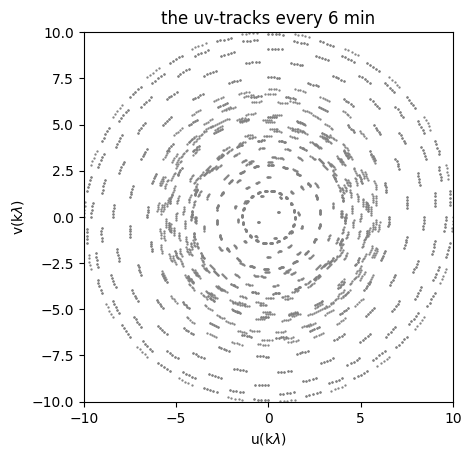

In [27]:
# Define the array latitude as if it was placed in Buenos Aires.


latitude= np.deg2rad(-37)    # -37°

# Define the source declination for a source at zenith.

source_declination = latitude

# Set up the observation parameters:
# - We will observe the source for 30 minutes.
# - We will start observing when the source is right above the array.
# - The data will be collected every 6 minutes.
# - We observe at 1.5 GHz (single frequency).

track_time = 0.5  # in hours (so 30 min)
t_0 =0.0    #the source is right above the array (zénith)
n_times = 5         # every 6min for 30 min     : 30/6 = 5 (step)
freq = 1.5e9
df=0
n_freqs =1

# Compute the uv-tracks

uv_tracks = antenna_utils.uv_track_multiband(baselines_enu, lat=latitude, dec=source_declination, track_time=track_time, t_0=t_0, n_times=n_times, f=freq, df=df,n_freqs=n_freqs, multi_band=False)[0]

# Plot the uv-tracks

plot_utils.plot_baselines(uv_tracks, ENU= False)
plt.title("the uv-tracks every 6 min")

In [7]:
print(uv_tracks)

[[-1.62507435e+03 -3.75177975e+02 -3.55517317e-14]
 [-3.25014869e+03 -7.50355949e+02  0.00000000e+00]
 [ 2.76252517e+03 -8.44588704e+02  7.11034634e-14]
 ...
 [ 2.43136748e+03  4.82159933e+03 -2.34908731e+02]
 [ 4.87359080e+02  4.85650006e+01 -5.08816501e+01]
 [ 7.57382020e+02  1.08178178e+01 -7.93401099e+01]]


Text(0.5, 1.0, 'the uv-tracks plot every 2min for 30min')

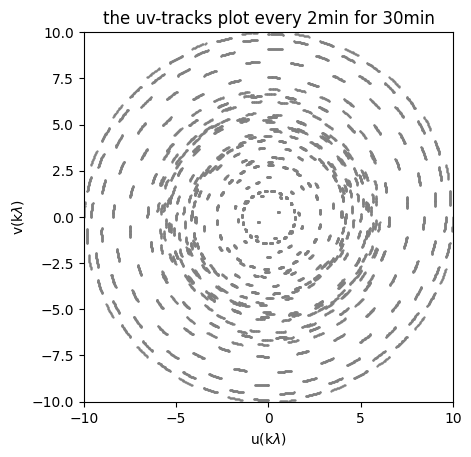

In [8]:
# Now the array will collect data every 2 minute. 

latitude= np.deg2rad(-37)    # -37°

source_declination = latitude

track_time = 0.5  # in hours (so 30min)
t_0 =0.0    #the source is right above the array (zénith)
n_times = 15        # 30/2 = 15 
freq = 1.5e9
df=0
n_freqs =1

# Compute the uv-tracks

uv_tracks = antenna_utils.uv_track_multiband(baselines_enu, lat=latitude, dec=source_declination, track_time=track_time, t_0=t_0, n_times=n_times, f=freq, df=df,n_freqs=n_freqs, multi_band=False)[0]

# Plot the uv-tracks

plot_utils.plot_baselines(uv_tracks, ENU= False)
plt.title("the uv-tracks plot every 2min for 30min")


Text(0.5, 1.0, 'uv-tracks plot every 2min for 1h')

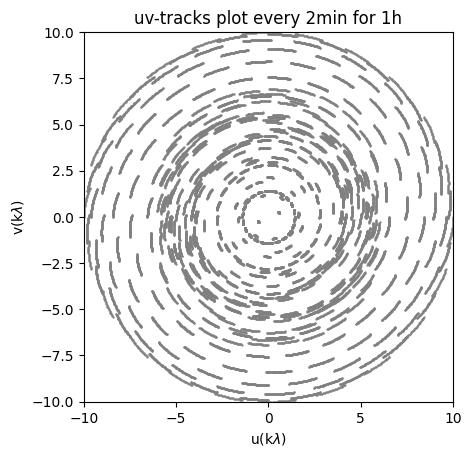

In [26]:
# Now we will observe for 1 hour. Compute the uv-tracks and plot them.
latitude= np.deg2rad(-37)    # -37°

source_declination = latitude

track_time = 1  # in hours 
t_0 =0.0    #the source is right above the array (zénith)
n_times = 30
freq = 1.5e9
df=0
n_freqs =1

# Compute the uv-tracks

uv_tracks = antenna_utils.uv_track_multiband(baselines_enu, lat=latitude, dec=source_declination, track_time=track_time, t_0=t_0, n_times=n_times, f=freq, df=df,n_freqs=n_freqs, multi_band=False)[0]

# Plot the uv-tracks

plot_utils.plot_baselines(uv_tracks, ENU= False)
plt.title("uv-tracks plot every 2min for 1h")

Text(0.5, 1.0, 'uv-tracks plot every 2 min for 1h with a 2h time difference  from the start time')

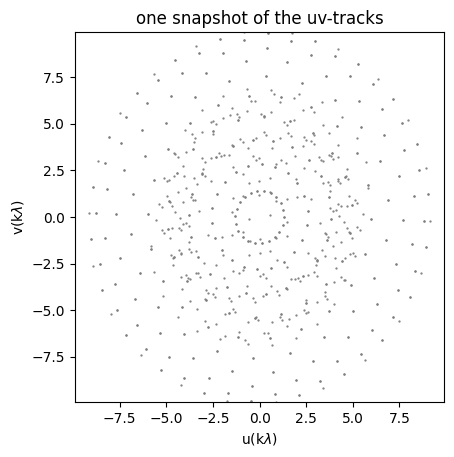

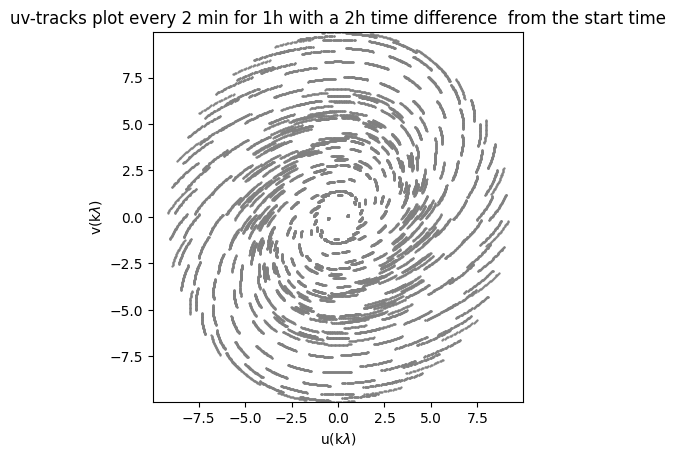

In [25]:
# Get only one snapshot ov the uv-tracks (n_times=1, track_time=0)

uv_tracks = antenna_utils.uv_track_multiband(baselines_enu, lat=latitude, dec=source_declination, track_time=0, t_0=t_0, n_times=1, f=freq, df=df,n_freqs=n_freqs, multi_band=False)[0]
plot_utils.plot_baselines(uv_tracks, ENU= False)
plt.title("one snapshot of the uv-tracks")



# Change the starting time and see how the uv-tracks change.

latitude= np.deg2rad(-37)    # -37°

source_declination = latitude

track_time = 1  # in hours 
t_0 =2    #the source is 2h after zénith
n_times = 30
freq = 1.5e9
df=0
n_freqs =1

# Compute the uv-tracks

uv_tracks_shifted = antenna_utils.uv_track_multiband(baselines_enu, lat=latitude, dec=source_declination, track_time=track_time, t_0=t_0, n_times=n_times, f=freq, df=df,n_freqs=n_freqs, multi_band=False)[0]

# Plot the uv-tracks

plot_utils.plot_baselines(uv_tracks_shifted, ENU= False)
plt.title("uv-tracks plot every 2 min for 1h with a 2h time difference  from the start time")


Describe how the uv-samples change when observing a source at different times. 

- when t_0 changes, the orientation of the uv tracks shifts
- the Earth's rotation moves the baselines over time 



How does observing for longer periods will affect the uv-samples? 
- the longer the observation, the more surface the uv-tracks cover
- for 30min, the points are less spread out, after 1hour, the curvature becomes more visible 

Would you expect the uv-samples to be more or less dense? 
- they become denser in certain areas
- a higher density means more information is available to reconstruct a more precise image

How would this affect the observation?
 - better resolution 
 - reduction of artifacts in the final image

### Multifrequency observation

We will stick to one time sample and observe at multiple 
frequencies.

NOTE: we won't split the uv samples in different bands, hence we will set up the `multi_band` parameter to its default value (`False`).

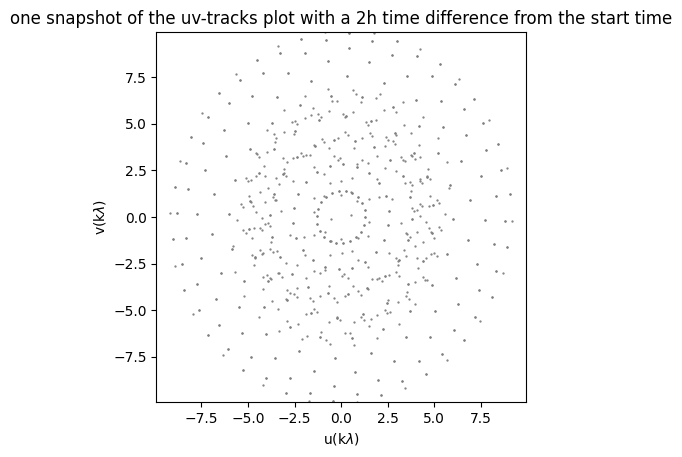

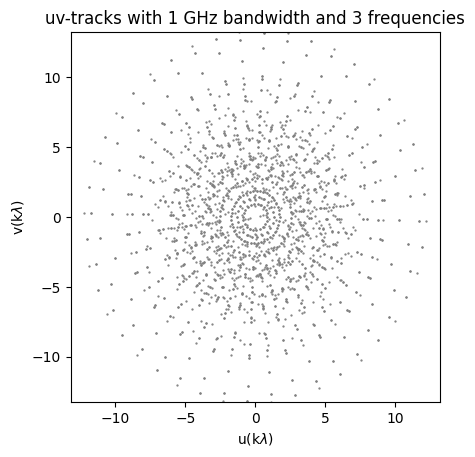

In [19]:
# Get only one snapshot of the uv-tracks (n_times=1, track_time=0) with the new starting time.
uv_tracks_shifted = antenna_utils.uv_track_multiband(baselines_enu, lat=latitude, dec=source_declination, track_time=0, t_0=t_0, n_times=1, f=freq, df=df,n_freqs=n_freqs, multi_band=False)[0]

# Plot the uv-tracks

plot_utils.plot_baselines(uv_tracks_shifted, ENU= False)
plt.title("one snapshot of the uv-tracks plot with a 2h time difference from the start time")


# Set up the central frequency to 1.5 GHz, a bandwidth of 1 GHz and 3 frequency channels.

freq_center = 1.5e9  # 1.5 GHz
bandwidth = 1e9  # 1 GHz
num_freqs = 3  # 3 frequency channels

# Compute the uv-tracks
uv_tracks_multi = antenna_utils.uv_track_multiband(baselines_enu, lat=latitude, dec=source_declination, track_time=0, t_0=t_0, n_times=1, f=freq_center, df=bandwidth, n_freqs=num_freqs, multi_band=False)[0]

# Plot the uv-tracks
plot_utils.plot_baselines(uv_tracks_multi, ENU=False)
plt.title("uv-tracks with 1 GHz bandwidth and 3 frequencies")
plt.show()


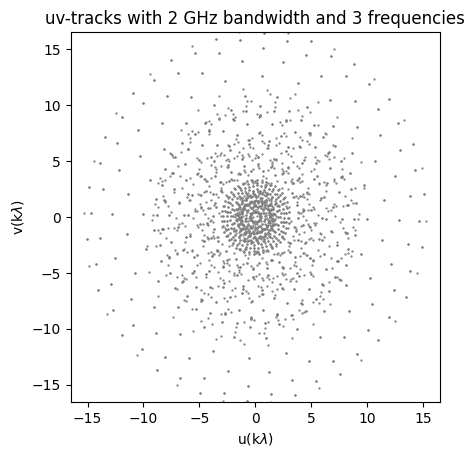

In [20]:
# Now increase the bandwith to 2 GHz.

bandwidth = 2e9  

# Compute the uv-tracks
uv_tracks_wideband = antenna_utils.uv_track_multiband(baselines_enu, lat=latitude, dec=source_declination, track_time=0, t_0=t_0, n_times=1, f=freq_center, df=bandwidth, n_freqs=num_freqs, multi_band=False)[0]

# Plot the uv-tracks
plot_utils.plot_baselines(uv_tracks_wideband, ENU=False)
plt.title("uv-tracks with 2 GHz bandwidth and 3 frequencies")
plt.show()

Describe the difference with respect to the previous case.

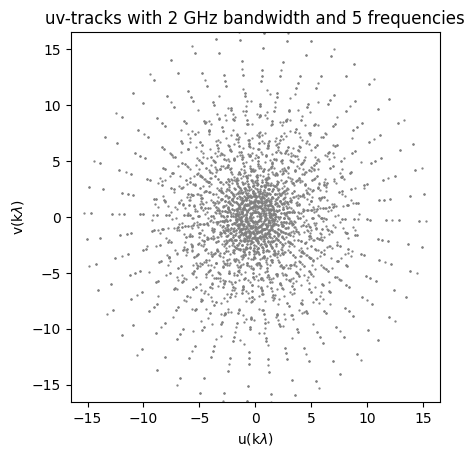

In [21]:
# Now add 2 more frequency channels.

num_freqs = 5  

# Compute the uv-tracks
uv_tracks_more_freqs = antenna_utils.uv_track_multiband(baselines_enu, lat=latitude, dec=source_declination, track_time=0, t_0=t_0, n_times=1, f=freq_center, df=bandwidth, n_freqs=num_freqs, multi_band=False)[0]

# Plot the uv-tracks
plot_utils.plot_baselines(uv_tracks_more_freqs, ENU=False)
plt.title("uv-tracks with 2 GHz bandwidth and 5 frequencies")
plt.show()

Describe the effect of observing at multiple frequencies, and how this can be used to improve the observation.

### Source tracking and multifrequency observation

We will now combine the two previous cases.

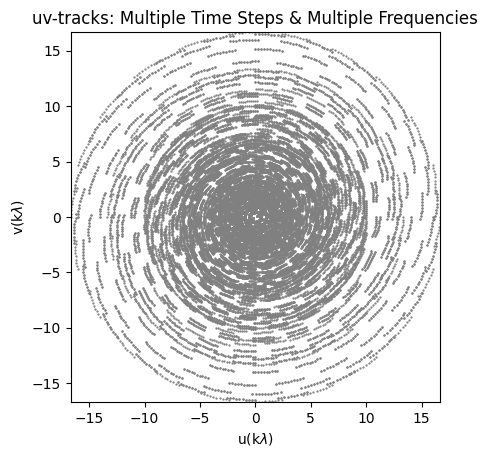

In [ ]:
# Propose an observation strategy where we have multiple time steps and multiple frequency channels.

# Define parameters for source tracking and multifrequency observation
track_time = 1  # Total observation time in hours
t_0 = 0  # Start tracking at transit
n_times = 10  # Number of time steps
freq_center = 1.5e9  # 1.5 GHz central frequency
bandwidth = 2e9  # 2 GHz total bandwidth
num_freqs = 5  # Number of frequency channels

# Compute the uv-tracks for multiple time steps and frequencies
uv_tracks_full = antenna_utils.uv_track_multiband(baselines_enu, lat=latitude, dec=source_declination, track_time=track_time, t_0=t_0, n_times=n_times, f=freq_center, df=bandwidth, n_freqs=num_freqs, multi_band=False)[0]

# Plot the uv-tracks
plot_utils.plot_baselines(uv_tracks_full, ENU=False)
plt.title("uv-tracks: Multiple Time Steps & Multiple Frequencies")
plt.show()

